In [ ]:
#TODO: Implement as script

In [1]:
import requests
import pandas as pd
import geopandas as gpd

In [2]:
url = "http://telemetriaws1.ana.gov.br/ServiceANA.asmx/HidroInventario?codEstDE=&codEstATE=&tpEst=&nmEst=&nmRio=&codSubBacia=&codBacia=&nmMunicipio=&nmEstado=&sgResp=&sgOper=&telemetrica="
response = requests.get(url=url)

In [3]:
stations = pd.read_xml(response.content, xpath=".//Table")

In [5]:
stations_geo = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.Longitude, stations.Latitude))

In [6]:
# filter outliers
stations_geo = stations_geo[stations_geo.Longitude > -100]

In [7]:
# get Brazilian boundaries
brazil = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/gadm_410-BRA.geojson", engine="pyogrio")

In [14]:
stations_geo["in_bounds"] = stations_geo.intersects(brazil.iloc[0].geometry)

In [26]:
stations_geo.to_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/water_quality/stations.feather")

---

In [58]:
import numpy as np
import pandas as pd
import zipfile
import seaborn as sns
import os
from datetime import datetime

In [6]:
root_path = "/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/water_quality/raw/"

In [7]:
files = pd.DataFrame({"filename": os.listdir(root_path)})
files["filesize"] = files.filename.apply(lambda x: os.path.getsize(f"{root_path}{x}"))
files["file_id"] = files.filename.str.extract(r"(^\d*)").iloc[:,0]
files = files.loc[((files.filesize > 22) & ~(files.file_id == "") & files.filename.str.contains(r"_csv.zip")),:]
files["file_id"] = files.file_id.astype(int)

In [9]:
dfs = [None] * files.shape[0]
for i in range(files.shape[0]):
    # open zip file
    with zipfile.ZipFile(f"{root_path}{files.filename.iloc[i]}", "r") as z:
        # prepare name of file in zipfile
        t_csvname = f"{files.file_id.iloc[i]}_QualAgua.csv"
        # check if a water quality file exists
        if t_csvname in [x.filename for x in z.filelist]:
            # get number of header lines to skip
            with z.open(t_csvname) as f:
                t_it = ""
                while not "EstacaoCodigo" in t_it:
                    t_it = f.readline().decode("latin-1")
                dfs[i] = pd.read_csv(f, names=t_it.split(";"), delimiter=";", encoding="latin-1")
        else: 
            dfs[i] = pd.DataFrame()

In [10]:
dfs = [y for y in [x for x in dfs if x is not None] if not y.empty]

In [11]:
dfs = pd.concat(dfs).copy()

In [ ]:
dfs[["pH", "OD", "TempAmostra", "Turbidez"]] = dfs[["pH", "OD", "TempAmostra", "Turbidez"]].apply(lambda x: x.str.replace(",", ".").astype(float), axis = 0)
dfs["Data"] = dfs["Data"].str.replace("/3", "/2")
dfs["date"] = pd.to_datetime(dfs["Data"], format="mixed", dayfirst=True)

In [71]:
dfs.to_feather("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/water_quality/quality_indicators.feather")

---

In [1]:
from datetime import datetime
import pandas as pd
import geopandas as gpd
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [2]:
dfs = pd.read_feather("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/water_quality/quality_indicators.feather")

In [14]:
dfs.loc[:,(dfs.isna().mean() < .5)]

,EstacaoCodigo,NivelConsistencia,Data,Hora,Choveu,TempAr,TempAmostra,pH,Turbidez,DBO,OD,SolTotais,NitrogenioAmoniacal,Nitratos,date
0,48839000,1.0,07/09/2022,15:29,2.0,"27,0",26.0,6.88,NaN,"4,0",7.30,"188,0",None,"0,08",2022-09-07
1,48839000,1.0,08/06/2022,15:50,2.0,"26,0",26.0,7.00,10.04,"1,67",6.20,"252,0",None,"0,08",2022-06-08
2,48839000,1.0,02/12/2021,07:40,1.0,"29,0",26.0,7.85,10.51,"0,85",6.00,"224,0",None,"0,08",2021-12-02
3,48839000,1.0,03/03/2021,10:00,1.0,"28,0",29.0,7.41,5.00,"2,8",5.20,"298,0",None,"0,08",2021-03-03
4,48839000,1.0,25/09/2019,10:30,0.0,"32,0",28.0,8.70,8.70,"3,6",9.50,"198,0","0,07","0,08",2019-09-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,66855000,1.0,26/05/2008,09:00,0.0,"19,0",21.4,6.85,NaN,None,8.76,None,None,None,2008-05-26
39,66855000,1.0,25/10/2007,12:00,1.0,"27,4",25.2,6.56,NaN,None,7.40,None,None,None,2007-10-25
40,66855000,1.0,04/07/2007,10:00,0.0,"24,6",20.3,7.28,NaN,None,8.07,None,None,None,2007-07-04
41,66855000,1.0,06/09/2003,11:10,0.0,"35,8",27.5,7.54,NaN,None,5.70,None,None,None,2003-09-06


In [7]:
plot_data = dfs.loc[:,["date", "pH", "EstacaoCodigo"]].reset_index()
# remove outliers
plot_data = plot_data.loc[((plot_data.pH < 12) & (plot_data.date < datetime.now())),:]

In [ ]:
sns.scatterplot(x = "date", y = "pH", alpha = .2, data = plot_data)

In [ ]:
sns.kdeplot(x = "date", y = "pH", fill=True, thresh=0, levels=100, cmap="mako", data = plot_data)

---

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
water_quality = pd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/water_quality/quality_indicators.feather")

water_quality[["DBO","SolTotais","NitrogenioAmoniacal","Nitratos"]] = water_quality[["DBO","SolTotais","NitrogenioAmoniacal","Nitratos"]].apply(lambda x: x.str.replace(",", "."), axis = 0).astype(float)

water_quality_panel = water_quality.groupby("EstacaoCodigo")[["pH","Turbidez","DBO","OD","SolTotais","NitrogenioAmoniacal","Nitratos","date"]].resample("1YE", on="date").mean()

# data cleaning
water_quality_panel["pH"] = water_quality_panel["pH"].apply(lambda x: x if 0 <= x <= 12 else np.nan)
water_quality_panel["Turbidez"] = water_quality_panel["Turbidez"].apply(lambda x: x if 0 <= x <= 100 else np.nan)
water_quality_panel["DBO"] = water_quality_panel["DBO"].apply(lambda x: x if 0 <= x <= 50 else np.nan)
water_quality_panel["OD"] = water_quality_panel["OD"].apply(lambda x: x if 0 <= x <= 200 else np.nan)
water_quality_panel["SolTotais"] = water_quality_panel["SolTotais"].apply(lambda x: x if 0 <= x <= 100 else np.nan)
water_quality_panel["NitrogenioAmoniacal"] = water_quality_panel["NitrogenioAmoniacal"].apply(lambda x: x if 0 <= x <= 100 else np.nan)
water_quality_panel["Nitratos"] = water_quality_panel["Nitratos"].apply(lambda x: x if 0 <= x <= 10 else np.nan)

water_quality_panel.reset_index(inplace=True)
water_quality_panel["year"] = water_quality_panel["date"].dt.year
water_quality_panel.drop(columns=["date"], inplace=True)

water_quality_panel.rename(
    columns={
        "EstacaoCodigo": "station",
        "Turbidez": "turbidity", 
        "DBO": "biochem_oxygen_demand",
        "OD": "dissolved_oxygen",
        "SolTotais": "total_residue",
        "NitrogenioAmoniacal": "total_nitrogen",
        "Nitratos": "nitrates"
        }, 
    inplace=True
    )

water_quality_panel.set_index(["station", "year"], inplace=True)

water_quality_panel.astype({x: np.float32 for x in ["turbidity", "biochem_oxygen_demand", "dissolved_oxygen", "total_residue", "total_nitrogen", "nitrates"]}).reset_index().to_parquet("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/water_quality/quality_indicators_panel.parquet")

---

In [1]:

import pandas as pd
pd.read_parquet("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/temp_extracted_land_cover/15.parquet").columns

Index(['1', '3', '4', '5', '6', '49', '10', '11', '12', '32', '29', '50', '13',
       '14', '15', '18', '19', '39', '20', '40', '62', '41', '36', '46', '47',
       '35', '48', '9', '21', '22', '23', '24', '30', '25', '26', '33', '31',
       '27', '0', 'total', 'forest', 'non-forest/natural', 'farming',
       'pasture', 'agriculture', 'non-vegetated', 'urban', 'mining', 'water',
       'deforestation', 'deforestation_f', 'deforestation_p',
       'deforestation_a', 'deforestation_u', 'deforestation_m', 'year'],
      dtype='object')

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from itertools import chain
rivers = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/shapefile.feather")
topology = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/topology.feather")

import sys
sys.path.append("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code")
from data.preprocess.river_network import calculate_distance_from_estuary

rivers = calculate_distance_from_estuary(rivers, topology)
# import os
# path = "/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/temp_extracted_land_cover"
# files = pd.Series(os.listdir(path))

# for file in files[files.str.contains(".feather")]:
#     os.replace(path + "/" + file, path + "/feather/" + file)
# stations = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/water_quality/stations.feather")
#
# stations_rivers = gpd.sjoin_nearest(stations.set_crs(4326).to_crs(5641), rivers)
# import shelve
# with shelve.open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/reachability.db") as reachability:
#     def worker(x):
#         if np.isnan(x.upstream_node_id):
#             return None
#         if not str(int(x.upstream_node_id)) in reachability:
#             return None
#         return reachability[str(int(x.upstream_node_id))]
#     stations_rivers["reachability"] = stations_rivers.apply(worker, axis=1)
# stations_rivers.to_pickle("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/water_quality/stations_rivers.pkl")
stations_rivers = pd.read_pickle("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/water_quality/stations_rivers.pkl")
drainage_polygons = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage/extracted_drainage_polygons.feather")
drainage_polygons_tmp = drainage_polygons[((~ drainage_polygons.is_empty) & (~ drainage_polygons.geometry.isna()))].drop(columns="geometry").reset_index(names = ["grid", "index"])
drainage_polygons_tmp = pd.merge(drainage_polygons_tmp, rivers.drop(columns = ["NORIOCOMP", "CORIO", "geometry"]), on = ["estuary", "river", "segment", "subsegment"])
drainage_polygons_tmp["identifier"] = drainage_polygons_tmp.apply(lambda x: [x["grid"], x["index"]], axis = 1)
node_polygon_lookup = drainage_polygons_tmp.set_index("upstream_node_id").groupby(level=0).apply(lambda x: x["identifier"].tolist()).to_dict()
del drainage_polygons_tmp
import dask.dataframe as dd
land_cover = dd.read_parquet("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/temp_extracted_land_cover/", columns=["year", "deforestation", "forest", "agriculture", "total"])
reachability_lookup = stations_rivers.set_index("Codigo", drop = True).reachability.apply(lambda x: list(x) if x else None)
reachability_lookup = reachability_lookup[~reachability_lookup.index.duplicated(keep='first')]
# distance_lookup = rivers.set_index("upstream_node_id", drop = True).distance_from_estuary
# distance_lookup.index.rename("node")
distance_lookup = rivers[["upstream_node_id", "distance_from_estuary"]].rename(columns={"upstream_node_id": "node"}).reset_index(drop = True)
station_distance_lookup = stations_rivers.set_index("Codigo", drop=True).distance_from_estuary
station_distance_lookup = station_distance_lookup[~station_distance_lookup.index.duplicated(keep='first')]
water_quality_panel = pd.read_parquet("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/water_quality/quality_indicators_panel.parquet")
station_codes = water_quality_panel.station.unique()
t_node_ids = {x: reachability_lookup.loc[x] for x in station_codes}
t_deforestation = land_cover.groupby(["grid_id", "index", "year"])[["deforestation", "forest", "agriculture", "total"]].sum().persist()
# assign chunks of 1M nodes
t_chunks = np.cumsum([len(x) if x is not None else 0 for i, x in t_node_ids.items()]) // 1e6
# get indices of chunks
t_chunks = [(int(np.argmax(t_chunks == i)), int(len(t_chunks) - np.argmax(t_chunks[::-1] == i) - 1)) for i in np.unique(t_chunks)]
# get nodes split into chunks
c_node_ids = [{y: t_node_ids[y] for y in list(t_node_ids.keys())[x[0]:x[1]]} for x in t_chunks]
#c_polygon_ids = [{station_id: {node_id: node_polygon_lookup.get(node_id, [None, None]) for node_id in node_ids if node_id is not None} for station_id, node_ids in chunk.items() if node_ids is not None} for chunk in c_node_ids]
out_df = [None] * len(c_node_ids)
for i in range(len(c_node_ids)):
    ## prepare data frame for final estimation
    # get polygon ids
    t_index_prep = {(key, int(value)): node_polygon_lookup.get(value, [None, None]) for key, values in c_node_ids[i].items() if values is not None for value in values}
    # combine in tuple for index
    t_index_prep = [(key[0], key[1], int(value[0]), int(value[1])) for key, values in t_index_prep.items() for value in values if value is not None]         
    # create dataframe with indices
    c_final_df = dd.from_pandas(pd.DataFrame().from_records(t_index_prep, columns = ["station", "node", "grid_id", "index"]))
    # merge with deforestation data
    c_final_df = dd.merge(c_final_df, t_deforestation.reset_index(), on = ["grid_id", "index"], how = "left")
    # merge with distance data
    c_final_df = dd.merge(c_final_df, dd.from_pandas(distance_lookup.dropna().astype({"node": int})), on="node")
    # calculate distance from station
    c_final_df["distance_from_station"] = (c_final_df.distance_from_estuary - c_final_df.station.map(station_distance_lookup, meta=('station', 'uint32'))).astype(np.uint32)
    
    # Define the windows
    max_ = 200 * 1e3; step_ = 20 * 1e3
    windows = np.arange(0, max_, step_)
    # Create bin labels
    bin_labels = [f"[{start},{start + step_})" for start in windows]
    # Bin the sorting column
    c_final_df['bins'] = c_final_df["distance_from_station"].map_partitions(pd.cut, bins=np.concatenate([windows, [max_ + step_]]), labels=bin_labels, right=False, include_lowest=True)
    
    # Group by the bins and sum the value column
    out_df[i] = c_final_df.groupby(["station", "year", "bins"])["deforestation", "forest", "agriculture", "total"].sum().astype(np.uint32).compute()
out_df = pd.concat(out_df)
out_df.reset_index().astype({"year": np.int32}).to_parquet("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/water_quality/land_cover_stations.parquet")

---

In [90]:
analysis_df = pd.merge(water_quality_panel, out_df, left_index=True, right_index=True)

analysis_df.reset_index().to_parquet("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/analysis/water_quality_analysis.parquet")

analysis_df["forest_share"] = analysis_df["forest"] / analysis_df["total"]

In [86]:
analysis_df.groupby("bins")[["forest_share", "turbidity"]].corr()

forest_share  turbidity
bins                                                      
(0,10000.0]          forest_share      1.000000  -0.188582
                     turbidity        -0.188582   1.000000
(10000.0,100000.0]   forest_share      1.000000  -0.165867
                     turbidity        -0.165867   1.000000
(100000.0,1000000.0] forest_share      1.000000  -0.072758
                     turbidity        -0.072758   1.000000

<Axes: xlabel='year'>

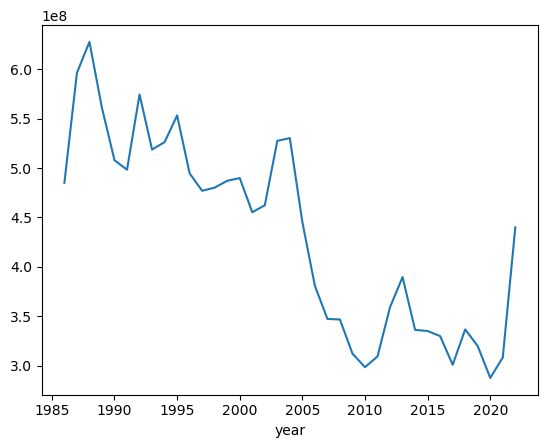

In [49]:
out_df.groupby("year").sum().deforestation.plot()

In [38]:
out_df.loc[:,:,"(0,10000.0]"].sum()

deforestation    1.410477e+08
forest           7.137306e+09
agriculture      1.567755e+09
total            1.848065e+10
dtype: float64

In [46]:
out_df.groupby("year").agg(lambda x: np.average(x.deforestation, weights=x.total))

AttributeError: 'Series' object has no attribute 'deforestation'

<Axes: ylabel='Frequency'>

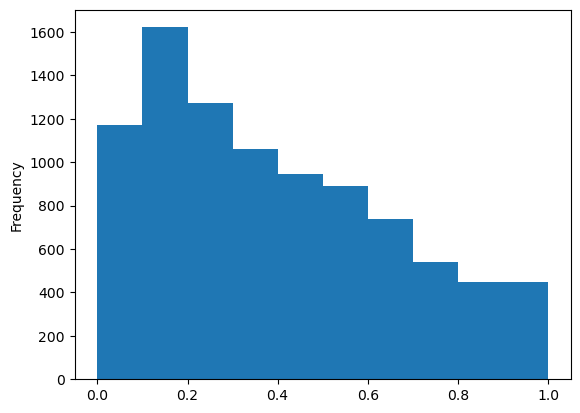

In [30]:
(out_df.forest / out_df.total).plot(kind="hist")

In [ ]:
"Flattens a nested list of variable depth"
def flatten(nested_list):
    flattened_list = []
    
    def _flatten(sublist):
        for item in sublist:
            if isinstance(item, list):
                _flatten(item)
            else:
                flattened_list.append(item)
    
    _flatten(nested_list)
    return flattened_list

In [ ]:
## split into subchunks
t_chunks = np.arange(len(c_node_ids_chunk)) // 5e1
t_chunks = [(int(np.argmax(t_chunks == i)), int(len(t_chunks) - np.argmax(t_chunks[::-1] == i) - 1)) for i in np.unique(t_chunks)]
c_node_ids_sub_chunks = [{y: c_node_ids_chunk[y] for y in list(c_node_ids_chunk.keys())[x[0]:x[1]]} for x in t_chunks]

In [ ]:
c_node_ids_sub_chunk = c_node_ids_sub_chunks[0]

In [ ]:
i = 0

In [ ]:
#for i in range(len(c_node_ids)):
c_node_ids_chunk = c_node_ids[i]

## prepare query from large df
# get unique ids of nodes in chunk
t_node_ids = np.unique(flatten(c_node_ids_chunk.values()))
# get polygons ids of nodes
t_nodes_polygons = {k: node_polygon_lookup.get(k, [None, None]) for k in t_node_ids}
# get all values that are not [None, None]
t_nodes_polygons_query = list(chain(*[v for k, v in t_nodes_polygons.items() if v != [None, None]]))
# prepare filter df
t_indices_df = pd.DataFrame(t_nodes_polygons_query, columns=['grid_id', 'index'], dtype=int)

## query the large df
# merge to filter
t_filtered_land_cover = land_cover.reset_index().merge(t_indices_df, on=['grid_id', 'index'], how='inner')
#t_filtered_land_cover = t_filtered_land_cover[t_filtered_land_cover.year.isin(x.index.get_level_values(1).year)]
# aggregate
t_deforestation = t_filtered_land_cover.groupby(["grid_id", "index", "year"])[["deforestation", "total"]].sum().compute()



KeyboardInterrupt: 

In [101]:
c_final_df

station   bins                
10200000  (10000.0,100000.0]        11915.0
          (100000.0,1000000.0]      12313.0
          (0,10000.0]                   0.0
10300000  (10000.0,100000.0]            0.0
          (100000.0,1000000.0]          0.0
                                    ...    
13408000  (10000.0,100000.0]      1291737.0
          (100000.0,1000000.0]     803227.0
13410000  (0,10000.0]                   0.0
          (10000.0,100000.0]      1725383.0
          (100000.0,1000000.0]    1891765.0
Name: deforestation, Length: 294, dtype: float64

In [ ]:

# Filter based on the list of indices
t_indices_df = pd.DataFrame(t_polygon_ids, columns=['grid_id', 'index'], dtype=int)

# Merge to filter
t_filtered_land_cover = land_cover.reset_index().merge(t_indices_df, on=['grid_id', 'index'], how='inner').compute()

t_filtered_land_cover = t_filtered_land_cover[t_filtered_land_cover.year.isin(x.index.get_level_values(1).year)]

t_deforestation = t_filtered_land_cover.groupby("year")[["deforestation", "total"]].sum()

In [119]:
def worker(x):
    t_polygon_ids = [node_polygon_lookup.get(x, [None, None]) for x in reachability_lookup.loc[x.name]]
    t_polygon_ids = [x for x in chain.from_iterable(t_polygon_ids) if x is not None]
    
    # Filter based on the list of indices
    t_indices_df = pd.DataFrame(t_polygon_ids, columns=['grid_id', 'index'], dtype=int)

    # Merge to filter
    t_filtered_land_cover = land_cover.reset_index().merge(t_indices_df, on=['grid_id', 'index'], how='inner').compute()
    
    t_filtered_land_cover = t_filtered_land_cover[t_filtered_land_cover.year.isin(x.index.get_level_values(1).year)]
    
    t_deforestation = t_filtered_land_cover.groupby("year")[["deforestation", "total"]].sum()
    
    return t_deforestation

In [ ]:
ax = topology.loc[list(reachability_lookup.loc[x.name[0]])].plot()
stations_rivers.loc[stations_rivers.Codigo == x.name[0],:].plot(ax =ax, color = "red")

In [ ]:
from itertools import chain

In [ ]:
t_deforestation.set_index()

In [18]:
land_cover.index.head(10)

MultiIndex([(0, 8),
            (0, 8),
            (0, 8),
            (0, 8),
            (0, 8),
            (0, 8),
            (0, 8),
            (0, 8),
            (0, 8),
            (0, 8)],
           names=['grid_id', 'index'])

In [257]:
index_df = pd.DataFrame(t_polygon_ids, columns=["grid_id", "index"])

# Step 4: Merge the Dask DataFrame with the index DataFrame to filter rows
filtered_df = land_cover.reset_index().merge(index_df, on=["grid_id", "index"]).set_index(["grid_id", "index"])

# Optionally, you can compute the filtered DataFrame
result = filtered_df.compute()

NotImplementedError: Dask dataframe does not yet support multi-indexes.
You tried to index with this index: ['grid_id', 'index']
Indexes must be single columns only.

In [250]:
len(t_polygon_ids)

46631

In [256]:
land_cover.head(0)

,,1,3,4,5,6,49,10,11,12,32,...,urban,mining,water,deforestation,deforestation_f,deforestation_p,deforestation_a,deforestation_u,deforestation_m,year
grid_id,index,,,,,,,,,,,,,,,,,,,,,


In [252]:
land_cover.loc[t_polygon_ids]

KeyError: 'Cannot index with list against unknown division. Try setting divisions using ``ddf.set_index``'

In [153]:
test = pd.read_parquet("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/temp_extracted_land_cover/525.parquet")

In [167]:
test.index.get_level_values(1).unique()

Index([   2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
       ...
       2507, 2508, 2509, 2510, 2511, 2512, 2515, 2516, 2517, 2519],
      dtype='int64', name='index', length=1260)

In [138]:
land_cover.head(1)

,,1,3,4,5,6,49,10,11,12,32,...,urban,mining,water,deforestation,deforestation_f,deforestation_p,deforestation_a,deforestation_u,deforestation_m,year
grid_id,index,,,,,,,,,,,,,,,,,,,,,
0,8,0,45049,0,0,0,0,0,5,123,0,...,0,0,0,57,0,0,0,0,0,1986


In [21]:
stations = stations.join(stations_rivers.loc[:,["adm2", "estuary", "distance_from_estuary"]])

In [24]:
stations.columns

Index(['id', 'rowOrder', 'BaciaCodigo', 'SubBaciaCodigo', 'RioCodigo',
       'RioNome', 'EstadoCodigo', 'nmEstado', 'MunicipioCodigo', 'nmMunicipio',
       'ResponsavelCodigo', 'ResponsavelSigla', 'ResponsavelUnidade',
       'ResponsavelJurisdicao', 'OperadoraCodigo', 'OperadoraSigla',
       'OperadoraUnidade', 'OperadoraSubUnidade', 'TipoEstacao', 'Codigo',
       'Nome', 'CodigoAdicional', 'Latitude', 'Longitude', 'Altitude',
       'AreaDrenagem', 'TipoEstacaoEscala', 'TipoEstacaoRegistradorNivel',
       'TipoEstacaoDescLiquida', 'TipoEstacaoSedimentos',
       'TipoEstacaoQualAgua', 'TipoEstacaoPluviometro',
       'TipoEstacaoRegistradorChuva', 'TipoEstacaoTanqueEvapo',
       'TipoEstacaoClimatologica', 'TipoEstacaoPiezometria',
       'TipoEstacaoTelemetrica', 'PeriodoEscalaInicio', 'PeriodoEscalaFim',
       'PeriodoRegistradorNivelInicio', 'PeriodoRegistradorNivelFim',
       'PeriodoDescLiquidaInicio', 'PeriodoDescLiquidaFim',
       'PeriodoSedimentosInicio', 'PeriodoSe

---

In [6]:
import os 
import pandas as pd
files = pd.Series(os.listdir("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/temp_extracted_land_cover"))
files = files[files.str.contains("parquet")]

In [7]:
files

1       109.parquet
2       754.parquet
7       291.parquet
9       275.parquet
10      110.parquet
           ...     
1667    318.parquet
1668    112.parquet
1669    753.parquet
1670    399.parquet
1671    764.parquet
Length: 1004, dtype: object

In [69]:
import dask.dataframe as dd
test = dd.read_parquet("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/temp_extracted_land_cover/*.parquet").drop(columns="0")

In [70]:
test[test.year == 2022].compute()

KeyboardInterrupt: 

In [71]:
test.query(f"`year` == 2022").compute()

1      3  4  5  6  49  10   11     12  32  ...  urban  mining  \
grid_id index                                             ...                  
8       0      0  32524  0  0  8   0   0  140  24108   0  ...      0       0   
        1      0      5  0  0  0   0   0    0      0   0  ...      0       0   
        18     0  21731  0  0  0   0   0    0      0   0  ...      0       0   
        19     0  11328  0  0  0   0   0    0      0   0  ...      0       0   
        25     0   1229  0  0  0   0   0    3     47   0  ...      0       0   
...           ..    ... .. .. ..  ..  ..  ...    ...  ..  ...    ...     ...   
1015    1673   0    221  0  0  0   0   0    0     11   0  ...      0       0   
        1674   0    284  0  0  0   0   0    0    104   0  ...      0       0   
        1675   0   1417  0  0  0   0   0    0     11   0  ...      0       0   
        1679   0   5808  0  0  0   0   0    0   7131   0  ...      0       0   
        1680   0      4  0  0  0   0   0    0      0   0  ...      0       0   

               water  deforestation  deforestation_f  deforestation_p  \
grid_id index                                                           
8       0         23            238               72               72   
        1          0              0                0                0   
        18         0              3                3                3   
        19         0              0                0                0   
        25       288             19                2                2   
...              ...            ...              ...              ...   
1015    1673       0              0                0                0   
        1674       0              2                2                0   
        1675       0              0                0                0   
        1679       0            134                8                0   
        1680       0              0                0                0   

               deforestation_a  deforestation_u  deforestation_m  year  
grid_id index                                                           
8       0                    0                0                0  2022  
        1                    0                0                0  2022  
        18                   0                0                0  2022  
        19                   0                0                0  2022  
        25                   0                0                0  2022  
...                        ...              ...              ...   ...  
1015    1673                 0                0                0  2022  
        1674                 0                0                0  2022  
        1675                 0                0                0  2022  
        1679                 2                0                0  2022  
        1680                 0                0                0  2022  

[931900 rows x 55 columns]

In [37]:
pd.read_parquet("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/temp_extracted_land_cover/")

0      979
1      260
2      749
3      868
4      702
      ... 
663    517
664    279
665    516
666    149
667    297
Name: 0, Length: 667, dtype: object

In [10]:
test = pd.read_feather(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/temp_extracted_land_cover/{525}.feather")
test.index.names = [None, None]

In [8]:
import geopandas as gpd
drainage_polygons = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage/extracted_drainage_polygons.feather")

In [15]:
test = test.query("year==2022").join(drainage_polygons, how = "left")

In [29]:
test["share_deforestation"] = np.log(test.deforestation / test.total + .001)

In [ ]:
import numpy as np
gpd.GeoDataFrame(test).plot(column = "share_deforestation", legend = True)

In [7]:
test.sort_values("deforestation")

1      3  4  5    6  49  10  11  12  32  ...  urban  mining  \
grid_id index                                           ...                  
525     1360   0      6  0  0    0   0   0   3   0   0  ...     16       0   
        11     0      0  0  0    0   0   0   0   0   0  ...      0       0   
        358    0   3601  0  0    0   0   0   0   0   0  ...      0       0   
        357    0   2127  0  0    0   0   0   0   0   0  ...      0       0   
        12     0      0  0  0    0   0   0   0   0   0  ...      0       0   
...           ..    ... .. ..  ...  ..  ..  ..  ..  ..  ...    ...     ...   
        2213   0  89222  0  0    0   0   0  58   0   0  ...      0       0   
        433    0  70699  0  0    5   0   0   0  12   0  ...      0       0   
        2035   0  86408  0  0  836   0   0   2  17   0  ...      0       0   
        2383   0   2747  0  0    0   0   0  12   6   0  ...      0       0   
        2213   0  99084  0  0    0   0   0  81   0   0  ...      0       0   

               water  deforestation  deforestation_f  deforestation_p  \
grid_id index                                                           
525     1360      12              0                0                0   
        11         0              0                0                0   
        358        0              0                0                0   
        357        0              0                0                0   
        12         0              0                0                0   
...              ...            ...              ...              ...   
        2213       6           9871             9869             9869   
        433       21          10328            10328            10328   
        2035      90          10339            10339            10339   
        2383       0          10445            10437            10437   
        2213       6          17906            17825            17825   

               deforestation_a  deforestation_u  deforestation_m  year  
grid_id index                                                           
525     1360                 0                0                0  2004  
        11                   0                0                0  2011  
        358                  0                0                0  1998  
        357                  0                0                0  1998  
        12                   0                0                0  2011  
...                        ...              ...              ...   ...  
        2213                 0                0                0  1988  
        433                  0                0                0  1995  
        2035                 0                0                0  1994  
        2383                 0                0                0  1988  
        2213                 0                0                0  1987  

[46620 rows x 56 columns]

In [6]:
land_cover = pd.concat([pd.read_feather(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/temp_extracted_land_cover/{x}") for x in files])
land_cover.index.names = [None, None]

: 

: 

In [145]:
drainage_polygons = gpd.read_feather("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/drainage/extracted_drainage_polygons.feather")

In [167]:
land_cover.index.get_level_values(0).unique()

Index([921, 450, 449, 533, 134, 419, 534, 220], dtype='int64')

<Axes: >

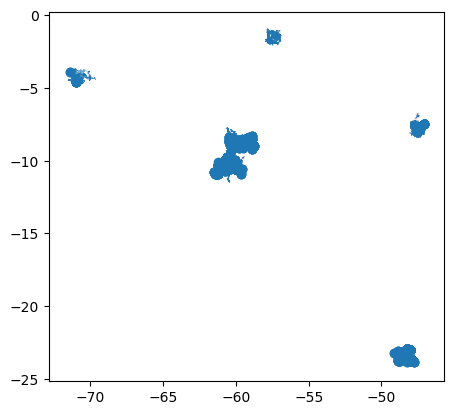

In [163]:
drainage_polygons.join(land_cover.query("year==2017"), how = "inner").plot()

In [146]:
drainage_polygons

estuary    river  segment  subsegment  distance_from_estuary  \
602  0       136.0  41388.0      0.0         0.0           3.468000e+06   
     1       136.0  41388.0      0.0         0.0           3.467000e+06   
     2       136.0  41388.0      0.0         0.0           3.466000e+06   
     3       136.0  41388.0      0.0         0.0           3.465000e+06   
     4       136.0  41388.0      0.0         0.0           3.464000e+06   
...            ...      ...      ...         ...                    ...   
1022 1519     29.0    170.0      0.0         0.0           3.260000e+05   
     1520     29.0    170.0      0.0         0.0           3.250000e+05   
     1521     29.0    170.0      0.0         0.0           3.240000e+05   
     1522     29.0    170.0      0.0         0.0           3.230000e+05   
     1523     29.0    170.0      0.0         0.0           3.227077e+05   

                                                    geometry  
602  0     MULTIPOLYGON (((-62.57772 -12.67584, -62.57712...  
     1     POLYGON ((-62.50037 -12.68141, -62.49949 -12.6...  
     2                                                  None  
     3                                                  None  
     4                                                  None  
...                                                      ...  
1022 1519  POLYGON ((-53.83375 -32.61792, -53.83458 -32.6...  
     1520  POLYGON ((-53.80375 -32.62292, -53.80375 -32.6...  
     1521  GEOMETRYCOLLECTION (POINT (-53.94517 -32.43767...  
     1522                                               None  
     1523                                               None  

[2726217 rows x 6 columns]

In [144]:
land_cover

1      3      4  5  6  49  10  11   12  32  ...  mining  water  \
grid_id index                                              ...                  
921     0      0  10583      0  0  0   0   0   0    0   0  ...       0      0   
        4      0   3463      0  0  0   0   0   0    0   0  ...       0      0   
        5      0    965      0  0  0   0   0   0    0   0  ...       0      0   
        6      0   2092      0  0  0   0   0   0    0   0  ...       0      6   
        7      0   1100      0  0  0   0   0   0    0   0  ...       0      0   
...           ..    ...    ... .. ..  ..  ..  ..  ...  ..  ...     ...    ...   
534     2641   0      0    706  0  0   0   0   0    0   0  ...       0      0   
        2642   0      0   1815  0  0   0   0   0   21   0  ...       0      0   
        2643   0      0  10559  0  0   0   0   0  481   0  ...       0      0   
        2646   0      0     64  0  0   0   0   0    1   0  ...       0      0   
        2647   0      0   1522  0  0   0   0   0    8   0  ...       0      0   

               deforestation  deforestation_f  deforestation_p  \
grid_id index                                                    
921     0                361              361                0   
        4                  8                8                0   
        5                268              268                0   
        6                123              121                0   
        7                  6                6                0   
...                      ...              ...              ...   
534     2641               1                1                1   
        2642               0                0                0   
        2643               5                5                0   
        2646               0                0                0   
        2647               1                1                1   

               deforestation_a  deforestation_u  deforestation_m  year   0  
grid_id index                                                               
921     0                    0                0                0  1986 NaN  
        4                    0                0                0  1986 NaN  
        5                    0                0                0  1986 NaN  
        6                    0                0                0  1986 NaN  
        7                    0                0                0  1986 NaN  
...                        ...              ...              ...   ...  ..  
534     2641                 0                0                0  2022 NaN  
        2642                 0                0                0  2022 NaN  
        2643                 0                0                0  2022 NaN  
        2646                 0                0                0  2022 NaN  
        2647                 0                0                0  2022 NaN  

[4412176 rows x 56 columns]

<Axes: >

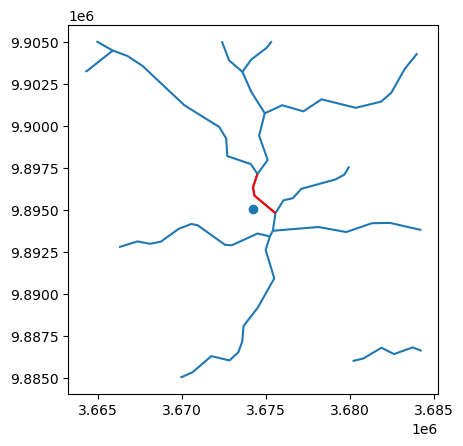

In [121]:
i = 50
# 
bbox = test.iloc[i].geometry.xy
ax = rivers.clip([bbox[0][0] - 10000, bbox[1][0] - 10000, bbox[0][0] + 10000, bbox[1][0]+ 10000]).plot()
test.iloc[[i]].plot(ax=ax)
rivers.loc[[tuple(test.iloc[i][["index_right0", "index_right1", "index_right2"]])]].plot(ax=ax, color="red")

In [80]:
rivers

NORIOCOMP        CORIO  \
0      0 0                                          Água Azul    8641516_0   
1      0 0                                        Água Bonita  864142512_0   
2      0 0                                        Água Bonita    8962984_0   
3      0 0  Água Bonita ou das Pontinhas e Água do Capão B...   86432922_0   
         1  Água Bonita ou das Pontinhas e Água do Capão B...   86432922_0   
...                                                       ...          ...   
161531 0 0                                               None         None   
161532 0 0                                               None         None   
161533 0 0                                               None         None   
161534 0 0                                               None         None   
161535 0 0                                               None         None   

            downstream_node_id  upstream_node_id    adm2  estuary    river  \
0      0 0             75450.0          493402.0  3110.0    228.0   9478.0   
1      0 0             75974.0          494325.0  2954.0    228.0   9551.0   
2      0 0             67065.0          485868.0  1559.0    228.0  12434.0   
3      0 0            153605.0          498582.0  4759.0    228.0   9153.0   
         1            153606.0          153605.0  4759.0    228.0   9153.0   
...                        ...               ...     ...      ...      ...   
161531 0 0                 NaN          487842.0     NaN   1023.0      0.0   
161532 0 0             68579.0          486433.0     NaN   1024.0      0.0   
161533 0 0             68579.0          486793.0     NaN   1024.0      1.0   
161534 0 0             67656.0           67491.0     NaN     60.0     28.0   
161535 0 0                 NaN           68579.0     NaN   1024.0      0.0   

            segment  subsegment  \
0      0 0      0.0         0.0   
1      0 0      0.0         0.0   
2      0 0      0.0         0.0   
3      0 0      2.0         0.0   
         1      1.0         0.0   
...             ...         ...   
161531 0 0      0.0         0.0   
161532 0 0      1.0         0.0   
161533 0 0      0.0         0.0   
161534 0 0      0.0         0.0   
161535 0 0      0.0         0.0   

                                                     geometry  
0      0 0  LINESTRING (4010130.381 7424922.032, 4011257.1...  
1      0 0  LINESTRING (4037777.378 7384298.361, 4037034.2...  
2      0 0  LINESTRING (3804922.764 8019931.350, 3804511.2...  
3      0 0  LINESTRING (4176882.178 7440871.707, 4175687.8...  
         1  LINESTRING (4170252.538 7442847.873, 4170252.1...  
...                                                       ...  
161531 0 0  LINESTRING (3849965.585 10605057.641, 3850608....  
161532 0 0  LINESTRING (3818121.855 10606360.696, 3818074....  
161533 0 0  LINESTRING (3826386.147 10608748.764, 3826293....  
161534 0 0  LINESTRING (3797879.886 10615132.380, 3797842....  
161535 0 0  LINESTRING (3822757.940 10616623.770, 3822687....  

[542107 rows x 10 columns]

---

In [1]:
import pandas as pd
import geopandas as gpd

In [41]:
test = pd.read_csv("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/water_quality/13150000_QualAgua.csv", sep=";", encoding="latin1", skiprows=16)

test[["pH", "OD", "TempAmostra", "Turbidez"]] = test[["pH", "OD", "TempAmostra", "Turbidez"]].apply(lambda x: x.str.replace(",", ".").astype(float), axis = 0)
test["date"] = pd.to_datetime(test["Data"], format="%d/%m/%Y")

In [29]:
test.loc[:,(test.isna().mean() < .5)]

,EstacaoCodigo,NivelConsistencia,Data,Hora,NumMedicao,PosHorizColeta,PosVertColeta,Choveu,TempAmostra,pH,Turbidez,CondutividadeEletrica,OD,date
0,13150000,1,12/10/2023,17:48,255.0,3,2.0,0.0,"31,9",7.23,"29,1",NaN,"5,87",2023-10-12
1,13150000,1,12/10/2023,18:11,255.0,1,2.0,0.0,"31,8",7.33,"27,1",NaN,"5,77",2023-10-12
2,13150000,1,12/10/2023,18:19,255.0,2,2.0,0.0,"31,9",7.35,"29,9",NaN,"5,82",2023-10-12
3,13150000,1,16/06/2023,16:50,254.0,2,2.0,0.0,"27,5",6.80,"38,3",NaN,"2,91",2023-06-16
4,13150000,1,16/06/2023,17:00,254.0,1,2.0,0.0,"27,6",6.82,"58,5",NaN,"3,0",2023-06-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,13150000,1,07/06/1975,15:10,5.0,1,3.0,0.0,"27,2",5.50,NaN,"54,1",NaN,1975-06-07
309,13150000,1,07/05/1975,16:00,4.0,1,3.0,0.0,"27,6",6.00,NaN,"109,0",NaN,1975-05-07
310,13150000,1,28/04/1975,14:40,3.0,1,3.0,0.0,"28,2",6.00,NaN,NaN,NaN,1975-04-28
311,13150000,1,08/04/1975,15:30,2.0,1,3.0,0.0,"27,8",6.00,NaN,NaN,NaN,1975-04-08


<Axes: xlabel='Data'>

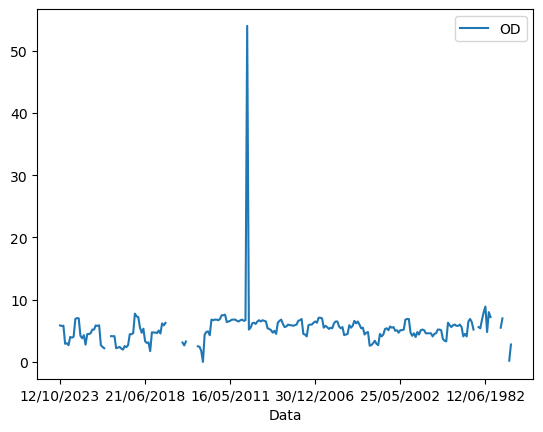

In [34]:
test.loc[:,["Data", "OD"]].plot(x="Data", y = "OD", kind="line")

<Axes: xlabel='Data'>

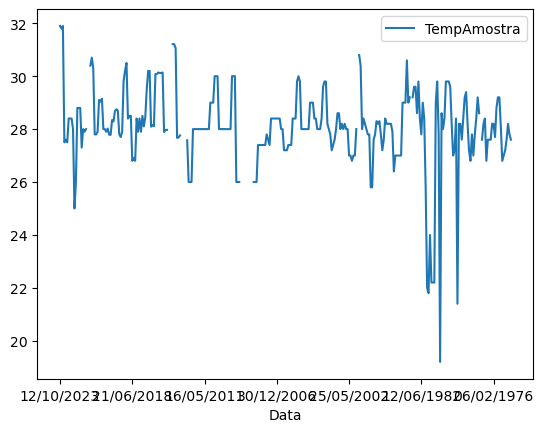

In [40]:
test.loc[:,["Data", "TempAmostra"]].plot(x="Data", y = "TempAmostra", kind="line")

<Axes: xlabel='Data'>

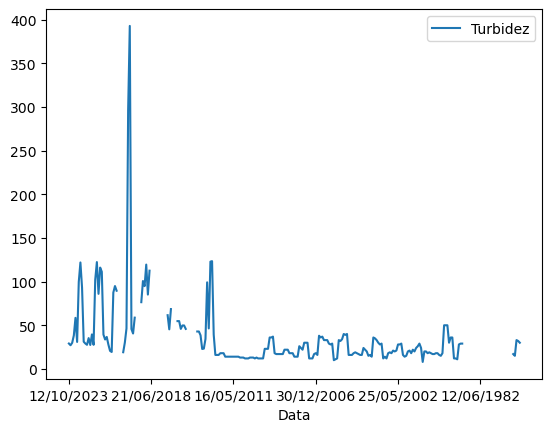

In [42]:
test.loc[:,["Data", "Turbidez"]].plot(x="Data", y = "Turbidez", kind="line")

<Axes: xlabel='Data'>

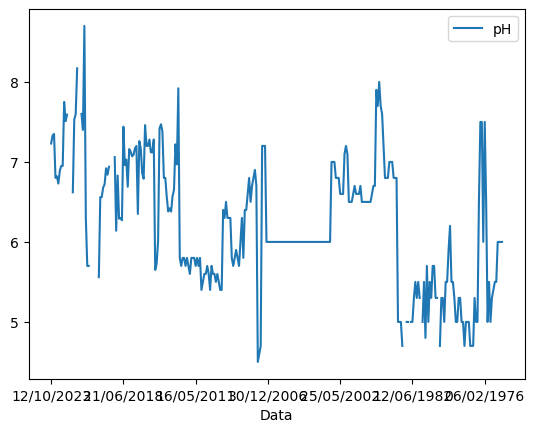

In [30]:
test.loc[:,["Data", "pH"]].plot(x="Data", y = "pH", kind="line")